<a href="https://colab.research.google.com/github/Jcc329/Jessica_DATA606/blob/main/Notebooks/5.Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data 606 Capstone
## Notebook 5
## Phase 2 Part 1: Topic Modeling
Jessica Conroy

<b> Goal: </b> 
This Notebook aims to perform topic modeling to identify key topics and differences in those topics among the pre covid and during covid time frames. 
1. LDA and NMF (non-negative matrix factorization) from game description, reviews, tags
2. Text similarity analysis

In [3]:
!pip install gensim==3.8.0

     |████████████████████████████████| 24.2 MB 1.5 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [72]:
pip install googletrans==3.1.0a0

  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16367 sha256=a8da55423c1f21e6773f52664a80dcf75a8505d2d06523d74706375d095f3eb6
  Stored in directory: /root/.cache/pip/wheels/0c/be/fe/93a6a40ffe386e16089e44dad9018ebab9dc4cb9eb7eab65ae
Successfully built googletrans
  Attempting uninstall: googletrans
    Found existing installation: googletrans 3.0.0
    Uninstalling googletrans-3.0.0:
      Successfully uninstalled googletrans-3.0.0


In [4]:
#Import libraries
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import textwrap

import gensim
print(gensim.__version__)
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LsiModel
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import preprocess_documents
from io import TextIOWrapper

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()

from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
# print(stopwords.words('english'))


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from googletrans import Translator

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

3.6.0
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


ModuleNotFoundError: ignored

In [5]:
#Load Data
# GameData = pd.read_csv('./FinalSteamData.csv')
GameData = pd.read_csv('./FinalGameData_postProcessing.csv')
# GameData.head()

# Perform some pre-requisite text processing

In [5]:
#Remove digits from tags. 

def removedigit(s):
    try:
        s = re.sub("\d+", "", s)
    except: 
        s
    return s
GameData['tags.1'] = GameData['tags.1'].apply(removedigit)
GameData['tags.1']

0        action  casual  arcade  shoot em up  d  colorf...
1                                                      NaN
2                                                      NaN
3        bullet hell  coop  shoot em up  replay value  ...
4        action  shooter  action rpg  shoot em up  rpg ...
                               ...                        
14947    adventure  indie  point  click  puzzle  short ...
14948                                                  NaN
14949                                   adventure  casual 
14950                                                  NaN
14951                                                  NaN
Name: tags.1, Length: 14952, dtype: object

In [6]:
#Lemmatize the text (Lemmatisation in linguistics is the process of grouping together the inflected forms of a word so they can be analysed as a single item)
# Topic modeling functions are informed and guided by another project I worked on https://github.com/Jcc329/Text_Summarization/blob/main/notebooks/Topic_Modeling_YunpengLi.ipynb
# used methods for lemmatizing found here https://www.geeksforgeeks.org/python-lemmatization-approaches-with-examples/

def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None
def nltk_lemmatize(s):
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(str(s))) 
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            # if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:       
            # else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    lemmatized_sentence = " ".join(lemmatized_sentence)
    return lemmatized_sentence
GameData['tags.1'] = GameData['tags.1'].apply(nltk_lemmatize)
# GameData['tags.1']
GameData['detailed_description.1'] = GameData['detailed_description.1'].apply(nltk_lemmatize)
# GameData['detailed_description.1']
GameData['Top Reviews by Upvotes.1'] = GameData['Top Reviews by Upvotes.1'].apply(nltk_lemmatize)
# GameData['Top Reviews by Upvotes.1']

In [7]:
#remove additional stopwords
stop_words = set(stopwords.words("english"))
stop_words = stop_words.update(["game",'games', "player", 'play'])

def removestopwords(s):
    #Remove stop words and sent to lowercase
    try:
        s = " ".join([word.lower() for word in str(s).split() if word.lower() not in stop_words])
    except:
        s
    return s

GameData['tags.1'] = GameData['tags.1'].apply(removestopwords)
# GameData['tags.1']
GameData['detailed_description.1'] = GameData['detailed_description.1'].apply(removestopwords)
# GameData['detailed_description.1']
GameData['Top Reviews by Upvotes.1'] = GameData['Top Reviews by Upvotes.1'].apply(removestopwords)
# GameData['Top Reviews by Upvotes.1']

In [9]:
# Filter out non english text
#https://pypi.org/project/googletrans/
#https://stackoverflow.com/questions/57282711/google-translate-library-is-printing-googletrans-models-translated-at-0x1eaf9bf

def taglanguage(df,col):
    lang_tag = []
    for s in df[col]:
        translator = Translator()
        result = translator.detect(s[0:100])
        lang_tag.append(result.lang)
    # print(lang.detect_language())
    return lang_tag

GameData['tags.Lang'] = taglanguage(GameData, 'tags.1')
# GameData['tags.1']
GameData['detailed_description.Lang'] =  taglanguage(GameData, 'detailed_description.1')
# GameData['detailed_description.1']
GameData['Top Reviews by Upvotes.Lang'] =  taglanguage(GameData, 'Top Reviews by Upvotes.1')
# GameData['detailed_description.Lang']
GameData.to_csv('./FinalGameData_postProcessing.csv')


0        en
1        en
2        en
3        en
4        en
         ..
14947    en
14948    en
14949    en
14950    en
14951    en
Name: detailed_description.Lang, Length: 14952, dtype: object

In [ ]:
from google.colab import files
files.download('FinalGameData_postProcessing.csv')

In [32]:
GameData[GameData['detailed_description.Lang']!='en']
GameData[GameData['detailed_description.Lang'].astype(str).str.contains('en')]['detailed_description.1'].values
#Nans were interpretted as [ht, zh-CN]	

array(['universe implodes interstellar nomad race get back home galaxy star violently push toward home threaten destroy nomad get catch path survive round relentless onslaught secure survival nomad game play several round round number nomad try make back home must defend swing intergalactic sword around fire projectile reflect galaxy star back origin key feature campaign span 60 mission mission increase duration difficulty random game experience random encounter implode verse simplistic control game fully play mouse huge sword attach nomad another one home sword point mouse cursor lmb reflect hazard adjacent sword rmb shoot projectile every sword toward position mouse cursor hazard collide sword destroy reflect hazard numerous type hazard require different approach hazard go home directly attack nomad multiple vector usually either tile bullet hell mechanic make round however boss round might mix match mechanic even add new one challenge you',
       'pilot rc drone target course rc ta

# Functions for preparing the text data for the LDA/NMF model application and doing coherence testing

In [15]:
#Split text into corpuses showing array of values
#Create Pre and During Covid data sets to use later:

GameData = GameData.fillna('')
preCOVID = GameData[GameData['Release Year'].isin([2018,2019])]
COVID = GameData[GameData['Release Year'].isin([2021,2022])]

GameData = GameData.fillna('')
# All Data
Descriptions_all = GameData[GameData['detailed_description.Lang'].astype(str).str.contains('en')]['detailed_description.1'].values
Reviews_all = GameData[GameData['Top Reviews by Upvotes.Lang'].astype(str).str.contains('en')]['Top Reviews by Upvotes.1'].values
Tags_all = GameData[GameData['tags.Lang'].astype(str).str.contains('en')]['tags.1'].values

# preCOVID Data
Descriptions_preCOVID = preCOVID[preCOVID['detailed_description.Lang'].astype(str).str.contains('en')]['detailed_description.1'].values
Reviews_preCOVID = preCOVID[preCOVID['Top Reviews by Upvotes.Lang'].astype(str).str.contains('en')]['Top Reviews by Upvotes.1'].values
Tags_preCOVID = preCOVID[preCOVID['tags.Lang'].astype(str).str.contains('en')]['tags.1'].values

# duringCOVID Data
Descriptions_COVID = COVID[COVID['detailed_description.Lang'].astype(str).str.contains('en')]['detailed_description.1'].values
Reviews_COVID = COVID[COVID['Top Reviews by Upvotes.Lang'].astype(str).str.contains('en')]['Top Reviews by Upvotes.1'].values
Tags_COVID = COVID[COVID['tags.Lang'].astype(str).str.contains('en')]['tags.1'].values

In [7]:
# Function to create dictionary, bag of words, and tokenized text: https://github.com/Jcc329/Text_Summarization/blob/main/notebooks/Topic_Modeling_YunpengLi.ipynb
# https://radimrehurek.com/gensim/parsing/preprocessing.html
def build_dictionary_preprocess_corpus(text_corpus):
  
  # Preprocess documents 
  tokenized_texts = preprocess_documents(text_corpus)
  
  # Create a dictionary
  dictionary = Dictionary(tokenized_texts)
  
  # Create a list of lists of bow for documents
  bow_corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

  return dictionary, bow_corpus, tokenized_texts

In [8]:
#Function for calculating coherence score: https://github.com/Jcc329/Text_Summarization/blob/main/notebooks/Topic_Modeling_YunpengLi.ipynb
# coherence_type can be 'u_mass' or 'c_v'
# algorithm can be 'LSI' or 'LDA'
def compute_coherence_score(tokenized_texts, bow_corpus, dictionary, num_topics, coherence_type, algorithm):
  if algorithm == 'LSI':
    model = LsiModel(corpus = bow_corpus, num_topics = num_topics, id2word = dictionary)
  else: # algorithm == 'LDA'
    model = LdaModel(corpus = bow_corpus, num_topics = num_topics, id2word = dictionary, passes = 2)

  coherence = CoherenceModel(model=model,
                              corpus=bow_corpus,
                              texts=tokenized_texts,
                              dictionary=dictionary,
                              coherence=coherence_type)
  return coherence.get_coherence()

In [9]:
def generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm, coherence_type='u_mass'):
  
  coherence_scores=[]
  min_score=0
  max_score=0

  best_num_topics=1

  for k in range(min_topics, max_topics):
    score = compute_coherence_score(tokenized_texts, bow_corpus, dictionary, k, coherence_type, algorithm)
    coherence_scores.append(score)

    if coherence_type == 'u_mass':
      if score < min_score :
        min_score = score
        best_num_topics = k
    else: # coherence_type == 'c_v'
      if score > max_score:
        max_score = score
        best_num_topics= k


  return coherence_scores, best_num_topics

In [10]:
#function for plotting coherence score
import matplotlib.pyplot as plt
import matplotlib.style as style
#%matplotlib inline

def plot_coherence_scores(min_topics, max_topics, coherence_scores, coherence_type, algorithm, legend=''):
  style.use('fivethirtyeight')

  x = [int(i) for i in range(min_topics, max_topics)]

  plt.figure(figsize=(10,8))
  plt.plot(x, coherence_scores)
  plt.xlabel('Number of topics')
  plt.ylabel('Coherence Value')
  plt.title(legend + ' ' + algorithm + ' Coherence Scores by number of Topics (' + coherence_type + ')')

In [11]:
#Function to print topics
def print_topics(dictionary, bow_corpus, num_topics, algorithm, num_words=10, friendly_print=True):
  
  if algorithm == 'LSI':
    model = LsiModel(corpus=bow_corpus, num_topics=num_topics, id2word=dictionary)
  else: # algorithm == 'LDA'
    model = LdaModel(corpus=bow_corpus, num_topics=num_topics, id2word=dictionary, passes=2)

  if friendly_print:
    # Extract terms from results returned by show_topic()
    for topic_number in range(0, num_topics):
      terms = []
      for term, wt in model.show_topic(topic_number, num_words):
        terms.append(term)
    
      print('Topic ' + str(topic_number) + ':', terms)

  else:
    topics = model.print_topics(num_topics, num_words)
    for topic in topics:
      print(topic)

  return model

## Functions for NMF Modeling

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import numpy as np

In [13]:
def print_NMF_topics(tokenized_texts, max_df=0.95, min_df=1, number_topics=20, number_words_per_topic=10):
  
  text_list=[]

  for token_array in tokenized_texts:
    text_list.append(" ".join(token_array))  # concat tokens for each document to make compatible format for vectorizer.fit_transform()

  vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df, stop_words='english')
  X = vectorizer.fit_transform(text_list)

  idx_to_word = np.array(vectorizer.get_feature_names())

  # apply NMF
  nmf = NMF(n_components=number_topics, solver="mu")
  W = nmf.fit_transform(X)  # document_topics
  H = nmf.components_       # topic_terms

  for i, topic in enumerate(H):
    print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in idx_to_word [topic.argsort()[-number_words_per_topic:]]])))

#Run the models

#All Data

## Descriptions

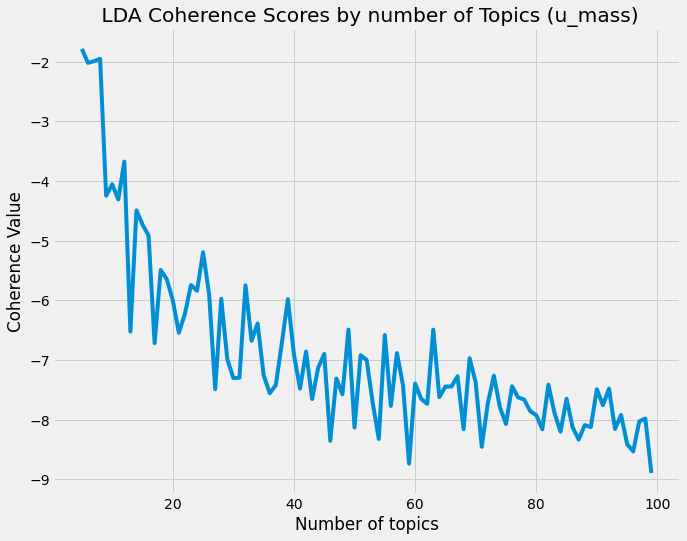

In [12]:
#We are using u_mass over c_v to calculate coherence because u_mass measures relationships with preceding and subsequent words and tends to perform better when compared with other coherence metrics (https://github.com/dice-group/Palmetto/issues/12)
dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(Descriptions_all)
min_topics, max_topics = 5, 100
coherence_scores_u_mass_lda, best_num_topics_u_mass_lda = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LDA', coherence_type='u_mass')
plot_coherence_scores(min_topics, max_topics, coherence_scores_u_mass_lda, coherence_type='u_mass', algorithm='LDA')

In [13]:
print('The best number of Description topics found by u-mass coherence score:', best_num_topics_u_mass_lda)

In [14]:
lda_model = print_topics(dictionary, bow_corpus, best_num_topics_u_mass_lda, algorithm='LDA', num_words=15, friendly_print=True)

The best number of Description topics found by u-mass coherence score: 99
Topic 0: ['knight', 'softwar', 'panel', 'particl', 'us', 'desktop', 'window', 'interfac', 'code', 'applic', 'tool', 'tabl', 'configur', 'custom', 'layer']
Topic 1: ['curs', 'pleasur', 'airship', 'district', 'archaeologist', 'adult', 'seed', 'loud', 'growth', 'evolutionari', 'newfound', 'album', 'smith', 'grown', 'decrypt']
Topic 2: ['industri', 'countri', 'republican', 'prime', 'mod', 'new', 'skull', 'spooki', 'self', 'slide', 'overview', 'respect', 'feder', 'prowl', 'enrich']
Topic 3: ['man', 'woman', 'men', 'samurai', 'coffe', 'spiritu', 'foot', 'hentai', 'walk', 'hot', 'drink', 'republ', 'playtim', 'laugh', 'theatr']
Topic 4: ['select', 'learn', 'costum', 'chang', 'us', 'comet', 'print', 'teach', 'bu', 'program', 'section', 'train', 'lesson', 'organ', 'interact']
Topic 5: ['island', 'game', 'gener', 'random', 'differ', 'tier', 'randomli', 'ship', 'dai', 'trade', 'time', 'player', 'new', 'procedur', 'world']
To

In [15]:
print_NMF_topics(tokenized_texts)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Topic 1: time,fight,weapon,differ,enemi,level,plai,mode,player,game
Topic 2: line,break,shoot,baseor,gamein,aboutquottig,tank,tanksthrough,topdown,enemi
Topic 3: youquot,new,plai,includ,authent,electr,song,tone,bass,guitar
Topic 4: updat,discount,late,note,twice,instal,care,costum,purchas,content
Topic 5: color,relax,piec,jigsaw,challeng,difficulti,solv,game,level,puzzl
Topic 6: wai,discov,life,dark,secret,explor,mysteri,stori,adventur,world
Topic 7: gamefeatureth,dlc,combat,larg,number,game,aboutthi,player,fighter,shoot
Topic 8: defeat,battl,dlc,base,contain,guard,reopen,indring,feature,tank
Topic 9: tile,quotrpg,charact,file,color,rpg,includ,skin,maker,pack
Topic 10: workshop,drive,line,steam,class,simul,rout,scenario,locomot,train
Topic 11: skill,dragon,power,charact,battl,spell,magic,dungeon,hero,monster
Topic 12: activ,ultim,subscript,adventur,licens,ruleset,map,pathfind,ground,fantasi
Topic 13: select,campaign,expans,brand,skin,dlc,unlock,add,charact,new
Topic 14: ogg,format,orig

## Reviews

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


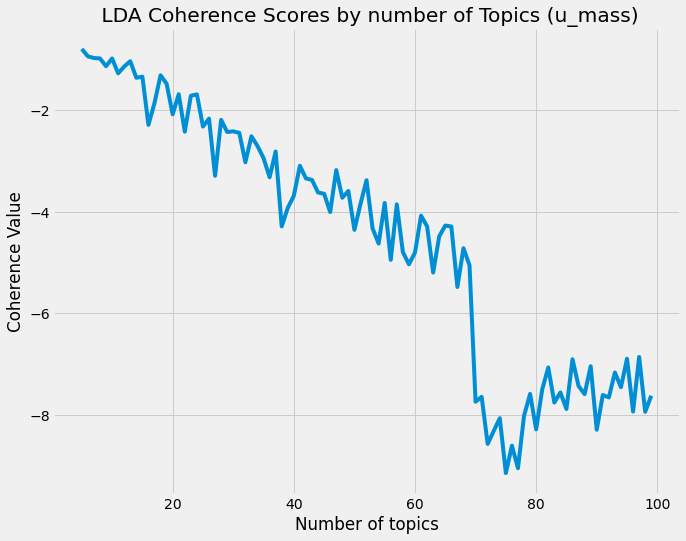

In [17]:
dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(Reviews_all)
min_topics, max_topics = 5, 100
coherence_scores_u_mass_lda, best_num_topics_u_mass_lda = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LDA', coherence_type='u_mass')
plot_coherence_scores(min_topics, max_topics, coherence_scores_u_mass_lda, coherence_type='u_mass', algorithm='LDA')

In [18]:
print('The best number of Review topics found by u-mass coherence score:', best_num_topics_u_mass_lda)

The best number of Review topics found by u-mass coherence score: 75


In [19]:
lda_model = print_topics(dictionary, bow_corpus, best_num_topics_u_mass_lda, algorithm='LDA', num_words=15, friendly_print=True)

Topic 0: ['garfield', 'game', 'dungeon', 'item', 'like', 'plai', 'us', 'charact', 'hurt', 'enemi', 'new', 'weapon', 'feel', 'skill', 'loot']
Topic 1: ['camo', 'dysfunct', 'rabbit', 'tattoo', 'clap', 'spa', 'synthesi', 'undriv', 'changeabl', 'mural', 'swt', 'game', 'thatedit', 'gaben', 'gatwick']
Topic 2: ['episod', 'chapter', 'comic', 'book', 'stori', 'game', 'pilgrim', 'seri', 'charact', 'jack', 'puzzl', 'good', 'like', 'great', 'deu']
Topic 3: ['hoyl', 'encor', 'atom', 'canasta', 'budapest', 'azur', 'smell', 'gax', 'langlei', 'raiselow', 'playeda', 'partnership', 'game', 'likethi', 'kitsch']
Topic 4: ['recip', 'nors', 'baldur', 'byzantin', 'vers', 'reaper', 'game', 'irish', 'groovi', 'preced', 'persian', 'portal', 'steve', 'antiqu', 'solasta']
Topic 5: ['gal', 'lyric', 'dungeoncrawl', 'tempest', 'homebrew', 'fuck', 'ye', 'jaw', 'glorious', 'booklet', 'thoughlov', 'pricei', 'httpsstoresteampoweredcomapplawlessland', 'retrosynth', 'fai']
Topic 6: ['game', 'sega', 'club', 'emul', 'genes

In [20]:
print_NMF_topics(tokenized_texts)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Topic 1: thing,review,good,think,look,develop,like,time,plai,game
Topic 2: click,jigsaw,pictur,nice,easi,object,stori,piec,solv,puzzl
Topic 3: want,add,free,content,base,worth,pack,new,bui,dlc
Topic 4: gameplai,boss,feel,like,time,jump,level,enemi,platform,control
Topic 5: simpl,easi,star,plai,complet,tower,achiev,challeng,game,level
Topic 6: averag,grind,music,nice,short,stori,price,graphic,pretti,good
Topic 7: love,scene,visual,art,short,choic,novel,end,charact,stori
Topic 8: love,tabl,onlin,control,multiplay,mode,fun,player,friend,plai
Topic 9: build,combat,attack,map,campaign,tower,mission,battl,enemi,unit
Topic 10: rule,match,bui,board,trade,solitair,plai,achiev,deck,card
Topic 11: sale,minut,littl,price,hard,pretti,worth,lot,short,fun
Topic 12: engin,cab,locomot,sound,loco,drive,scenario,train,car,rout
Topic 13: girl,car,pretti,nice,art,wish,look,stuff,feel,like
Topic 14: listen,guitar,rhythm,bui,track,bass,pack,soundtrack,music,song
Topic 15: nice,color,charact,costum,weapon,loo

## Tags

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


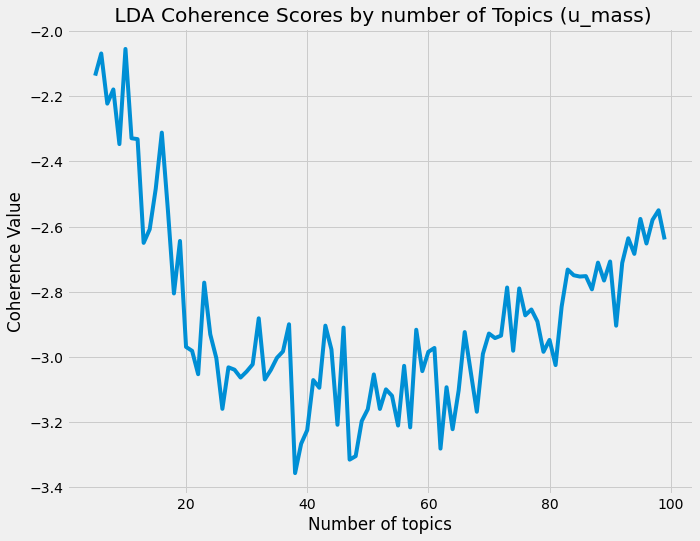

In [21]:
dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(Tags_all)
min_topics, max_topics = 5, 100
coherence_scores_u_mass_lda, best_num_topics_u_mass_lda = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LDA', coherence_type='u_mass')
plot_coherence_scores(min_topics, max_topics, coherence_scores_u_mass_lda, coherence_type='u_mass', algorithm='LDA')

In [22]:
print('The best number of Review topics found by u-mass coherence score:', best_num_topics_u_mass_lda)

The best number of Review topics found by u-mass coherence score: 38


In [23]:
lda_model = print_topics(dictionary, bow_corpus, best_num_topics_u_mass_lda, algorithm='LDA', num_words=15, friendly_print=True)

Topic 0: ['rich', 'stori', 'adventur', 'atmospher', 'mysteri', 'singleplay', 'horror', 'indi', 'puzzl', 'great', 'soundtrack', 'explor', 'dark', 'narrat', 'detect']
Topic 1: ['platform', 'action', 'adventur', 'scroller', 'actionadventur', 'singleplay', 'indi', 'pixel', 'graphic', 'color', 'cute', 'metroidvania', 'control', 'puzzleplatform', 'precis']
Topic 2: ['sim', 'martial', 'art', 'immers', 'simul', 'vision', 'medic', 'singleplay', 'casual', 'fight', 'modern', 'realist', 'indi', 'histor', 'life']
Topic 3: ['open', 'world', 'drive', 'simul', 'automobil', 'train', 'sim', 'race', 'product', 'sandbox', 'video', 'audio', 'bike', 'indi', 'surviv']
Topic 4: ['multiplay', 'massiv', 'plai', 'free', 'action', 'rpg', 'adventur', 'indi', 'pvp', 'strategi', 'coop', 'casual', 'simul', 'sandbox', 'mmorpg']
Topic 5: ['manag', 'strategi', 'time', 'rt', 'singleplay', 'resourc', 'tactic', 'realtim', 'basebuild', 'real', 'simul', 'citi', 'builder', 'build', 'sandbox']
Topic 6: ['matter', 'choic', 'mul

In [24]:
print_NMF_topics(tokenized_texts)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Topic 1: difficult,fight,soundtrack,actionadventur,slash,hack,roguelik,adventur,indi,action
Topic 2: singleplay,world,sandbox,realist,flight,sim,walk,manag,casual,simul
Topic 3: femal,protagonist,fantasi,explor,great,soundtrack,atmospher,singleplay,stori,rich
Topic 4: space,histor,war,multiplay,grand,defens,tower,rt,manag,strategi
Topic 5: surviv,player,pvp,open,onlin,world,massiv,local,coop,multiplay
Topic 6: interact,fiction,novel,visual,rpg,rpgmaker,choos,textbas,indi,adventur
Topic 7: card,casual,sport,clicker,indi,rpg,multiplay,massiv,free,plai
Topic 8: open,massiv,hack,slash,roguelik,jrpg,fantasi,rpgmaker,indi,rpg
Topic 9: fp,gore,zombi,atmospher,dark,indi,firstperson,psycholog,surviv,horror
Topic 10: difficult,precis,adventur,retro,scroller,puzzleplatform,graphic,pixel,indi,platform
Topic 11: illustr,design,sim,craft,build,sandbox,util,casual,earli,access
Topic 12: detect,famili,friendli,mysteri,adventur,casual,click,point,hidden,object
Topic 13: soccer,offroad,esport,footbal,si

#Pre-Covid
## Descriptions

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


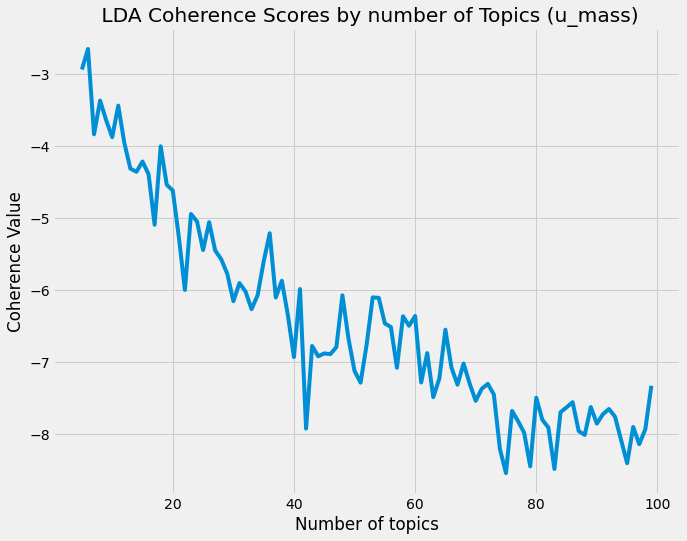

In [25]:
dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(Descriptions_preCOVID)
min_topics, max_topics = 5, 100
coherence_scores_u_mass_lda, best_num_topics_u_mass_lda = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LDA', coherence_type='u_mass')
plot_coherence_scores(min_topics, max_topics, coherence_scores_u_mass_lda, coherence_type='u_mass', algorithm='LDA')

In [26]:
print('The best number of Review topics found by u-mass coherence score:', best_num_topics_u_mass_lda)

The best number of Review topics found by u-mass coherence score: 75


In [27]:
lda_model = print_topics(dictionary, bow_corpus, best_num_topics_u_mass_lda, algorithm='LDA', num_words=15, friendly_print=True)

Topic 0: ['escap', 'black', 'professor', 'episod', 'game', 'topic', 'mysteri', 'need', 'teach', 'wrong', 'complet', 'lesson', 'lock', 'new', 'surviv']
Topic 1: ['dog', 'bedroom', 'shark', 'sail', 'machin', 'teach', 'otherworldli', 'quad', 'chen', 'maroon', 'stroll', 'tecmo', 'eccentr', 'game', 'scientist']
Topic 2: ['knight', 'gem', 'reliabl', 'new', 'vert', 'runandgun', 'villain', 'eon', 'equip', 'final', 'black', 'plai', 'sakura©', 'wishlist', 'minigam']
Topic 3: ['belong', 'geometri', 'polygon', 'uplift', 'clerk', 'instal', 'catastroph', 'entangl', 'imprison', 'garden', 'audienc', 'ninja', 'driver', 'game', 'king']
Topic 4: ['content', 'purchas', 'us', 'costum', 'select', 'charact', 'care', 'avail', 'instal', 'twice', 'note', 'set', 'angel', 'late', 'ring']
Topic 5: ['plai', 'tone', 'new', 'histor', 'includ', 'electr', 'guitar', 'authent', 'bass', 'song', 'queen', 'polit', 'youquot', 'crypto', 'leader']
Topic 6: ['attack', 'monster', 'control', 'mous', 'leav', 'need', 'shoe', 'costu

In [28]:
print_NMF_topics(tokenized_texts)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Topic 1: attack,time,skill,weapon,fight,differ,mode,plai,enemi,game
Topic 2: price,note,discount,late,costum,instal,twice,care,purchas,content
Topic 3: youquot,new,plai,includ,song,electr,authent,bass,guitar,tone
Topic 4: relax,contain,complet,level,difficulti,piec,jigsaw,solv,game,puzzl
Topic 5: island,dark,life,secret,charact,explor,mysteri,stori,world,adventur
Topic 6: action,men,festa,titl,young,rhythm,rout,quotla,corda,doro
Topic 7: enjoi,origin,includ,art,file,wallpap,artbook,folder,game,dlc
Topic 8: allow,game,effect,warrior,offic,appli,correspond,trialquot,quotdynasti,ticket
Topic 9: ultim,ruleset,licens,subscript,higherrequir,monster,pathfind,map,ground,fantasi
Topic 10: costumequot,hideawai,galleri,menu,outfit,regular,charact,chang,costum,select
Topic 11: mode,multiplay,ball,team,enjoi,interact,game,amus,gestur,player
Topic 12: battl,add,pack,dlc,campaign,skin,unit,mission,weapon,new
Topic 13: scenario,locomot,liveri,vehicl,passeng,simul,drive,race,train,car
Topic 14: rpg,bgm

## Reviews

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


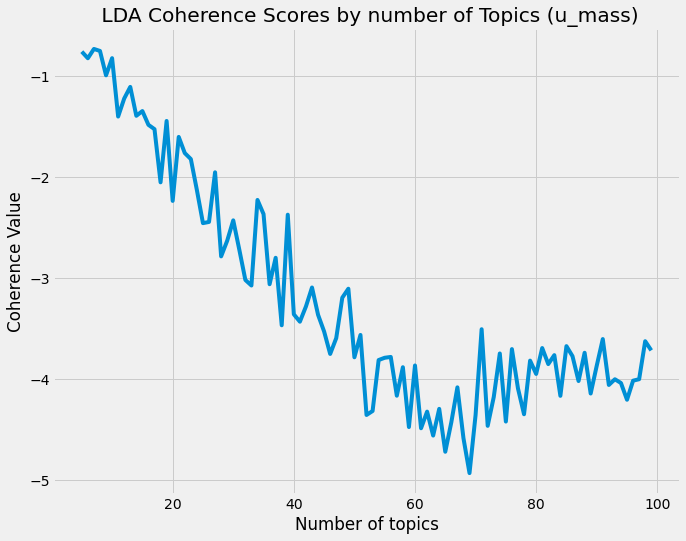

In [29]:
dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(Reviews_preCOVID)
min_topics, max_topics = 5, 100
coherence_scores_u_mass_lda, best_num_topics_u_mass_lda = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LDA', coherence_type='u_mass')
plot_coherence_scores(min_topics, max_topics, coherence_scores_u_mass_lda, coherence_type='u_mass', algorithm='LDA')

In [30]:
print('The best number of Review topics found by u-mass coherence score:', best_num_topics_u_mass_lda)

The best number of Review topics found by u-mass coherence score: 69


In [31]:
lda_model = print_topics(dictionary, bow_corpus, best_num_topics_u_mass_lda, algorithm='LDA', num_words=15, friendly_print=True)

Topic 0: ['game', 'like', 'mma', 'good', 'plai', 'great', 'dai', 'fighter', 'look', 'time', 'bui', 'puzzl', 'monei', 'love', 'fight']
Topic 1: ['charact', 'us', 'tranzient', 'piano', 'shudder', 'plagu', 'game', 'plai', 'music', 'klei', 'new', 'midi', 'free', 'function', 'like']
Topic 2: ['game', 'unit', 'battl', 'gamebook', 'plow', 'good', 'like', 'look', 'us', 'time', 'bad', 'plai', 'issu', 'turn', 'save']
Topic 3: ['game', 'like', 'good', 'plai', 'fun', 'gun', 'develop', 'time', 'map', 'bui', 'feel', 'player', 'earli', 'updat', 'bug']
Topic 4: ['dlc', 'new', 'game', 'ship', 'bui', 'add', 'good', 'like', 'campaign', 'time', 'fleet', 'us', 'plai', 'best', 'base']
Topic 5: ['game', 'like', 'plai', 'good', 'time', 'enemi', 'charact', 'fun', 'us', 'look', 'stori', 'feel', 'level', 'thing', 'bui']
Topic 6: ['game', 'puzzl', 'pictur', 'level', 'achiev', 'piec', 'like', 'plai', 'fun', 'good', 'music', 'easi', 'nice', 'price', 'time']
Topic 7: ['game', 'bui', 'dlc', 'childhood', 'crunch', 'st

In [32]:
print_NMF_topics(tokenized_texts)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Topic 1: recommend,work,think,wai,develop,need,like,time,plai,game
Topic 2: mechan,great,challeng,solut,relax,jigsaw,pictur,solv,piec,puzzl
Topic 3: art,time,feel,scene,novel,like,choic,end,charact,stori
Topic 4: bass,soooooooooooooooooooooo,stuff,graphic,match,art,stori,game,usual,good
Topic 5: difficulti,hard,editor,enemi,design,finish,good,challeng,platform,level
Topic 6: purchas,monei,librari,best,costum,worth,pack,new,bui,dlc
Topic 7: kid,challeng,sale,cute,easi,littl,friend,hard,short,fun
Topic 8: fast,bui,profil,min,unlock,steam,easi,hunter,game,achiev
Topic 9: look,plane,fly,engin,locomot,aircraft,train,sound,work,car
Topic 10: map,fast,version,excit,like,expert,pack,plai,music,song
Topic 11: win,hog,expans,board,player,trade,solitair,plai,deck,card
Topic 12: boss,damag,attack,kill,wave,shooter,shoot,gun,weapon,enemi
Topic 13: piec,dev,look,potenti,softwar,support,feel,amaz,art,like
Topic 14: look,definit,bit,graphic,game,soundtrack,great,relax,music,nice
Topic 15: freight,grea

## Tags

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


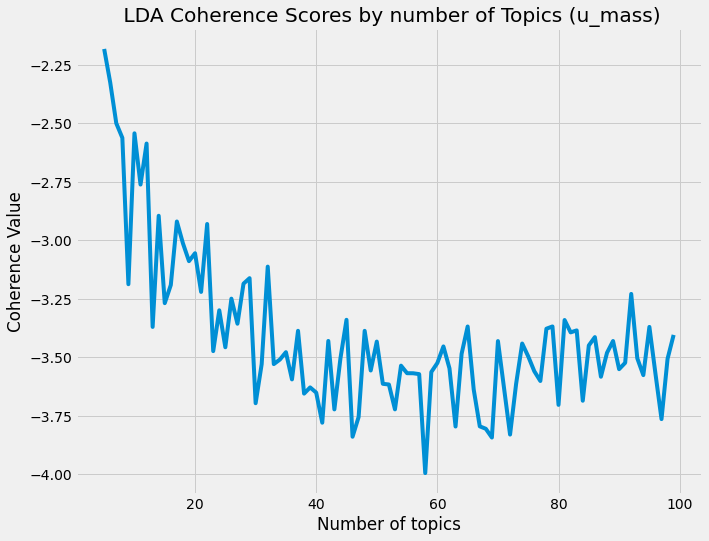

In [33]:
dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(Tags_preCOVID)
min_topics, max_topics = 5, 100
coherence_scores_u_mass_lda, best_num_topics_u_mass_lda = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LDA', coherence_type='u_mass')
plot_coherence_scores(min_topics, max_topics, coherence_scores_u_mass_lda, coherence_type='u_mass', algorithm='LDA')

In [34]:
print('The best number of Review topics found by u-mass coherence score:', best_num_topics_u_mass_lda)

The best number of Review topics found by u-mass coherence score: 58


In [35]:
lda_model = print_topics(dictionary, bow_corpus, best_num_topics_u_mass_lda, algorithm='LDA', num_words=15, friendly_print=True)

Topic 0: ['trade', 'idler', 'crpg', 'fantasi', 'romanc', 'faith', 'indi', 'rpg', 'anim', 'tabletop', 'casual', 'clicker', 'card', 'partybas', 'end']
Topic 1: ['adventur', 'indi', 'action', 'choos', 'textbas', 'dungeon', 'rpg', 'interact', 'loot', 'fiction', 'pixel', 'graphic', 'singleplay', 'crawler', 'local']
Topic 2: ['violent', 'action', 'gore', 'indi', 'earli', 'access', 'adventur', 'rpg', 'horror', 'western', 'hunt', 'surviv', 'world', 'open', 'shooter']
Topic 3: ['art', 'martial', 'soundtrack', 'indi', 'great', 'casual', 'charact', 'adventur', 'explor', 'rpg', 'custom', 'action', 'fighter', 'access', 'earli']
Topic 4: ['casual', 'indi', 'puzzl', 'famili', 'friendli', 'singleplay', 'relax', 'difficult', 'logic', 'minimalist', 'strategi', 'music', 'procedur', 'gener', 'runner']
Topic 5: ['indi', 'casual', 'singleplay', 'plai', 'free', 'underwat', 'puzzl', 'short', 'fastpac', 'adventur', 'action', 'strategi', 'horror', 'friendli', 'famili']
Topic 6: ['horror', 'psycholog', 'indi', '

In [36]:
print_NMF_topics(tokenized_texts)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Topic 1: tank,nuditi,music,educ,simul,arcad,action,adventur,casual,indi
Topic 2: actionadventur,beat,roguelit,shoot,slash,hack,roguelik,difficult,adventur,action
Topic 3: surviv,singleplay,train,realist,strategi,walk,sim,manag,action,simul
Topic 4: puzzleplatform,fmv,explor,click,point,rpg,rpgmaker,choos,textbas,adventur
Topic 5: horror,singleplay,puzzleplatform,difficult,card,clicker,multiplay,massiv,plai,free
Topic 6: rpg,space,board,manag,rt,tower,defens,action,indi,strategi
Topic 7: atmospher,funni,retro,graphic,pixel,difficult,great,soundtrack,singleplay,platform
Topic 8: indi,craft,sandbox,world,open,roguelik,fp,rpg,earli,access
Topic 9: slash,roguelit,partybas,fantasi,roguelik,jrpg,textbas,anim,rpgmaker,rpg
Topic 10: dinosaur,dark,surviv,zombi,fp,nuditi,horror,indi,gore,violent
Topic 11: golf,arcad,drive,motorbik,footbal,basketbal,automobil,indi,race,sport
Topic 12: violent,time,board,multiplay,sport,card,game,action,adventur,casual
Topic 13: nsfw,meme,protagonist,femal,hentai,m

# Covid Data
## Description

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


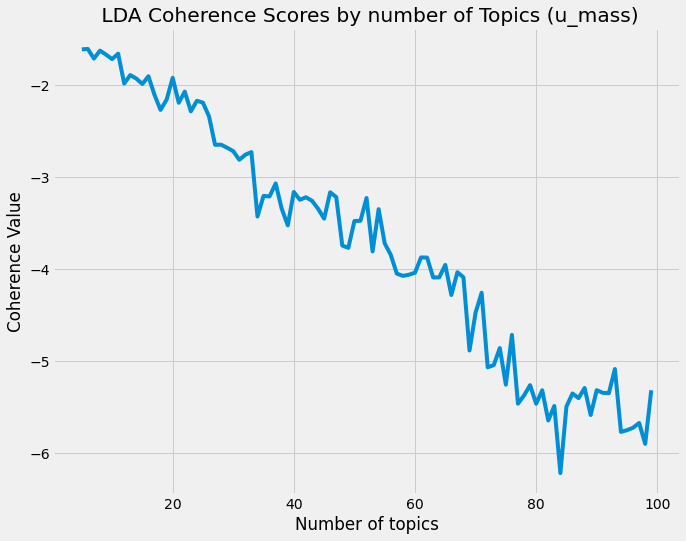

In [37]:
dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(Descriptions_COVID)
min_topics, max_topics = 5, 100
coherence_scores_u_mass_lda, best_num_topics_u_mass_lda = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LDA', coherence_type='u_mass')
plot_coherence_scores(min_topics, max_topics, coherence_scores_u_mass_lda, coherence_type='u_mass', algorithm='LDA')

In [38]:
print('The best number of Review topics found by u-mass coherence score:', best_num_topics_u_mass_lda)

The best number of Review topics found by u-mass coherence score: 84


In [39]:
lda_model = print_topics(dictionary, bow_corpus, best_num_topics_u_mass_lda, algorithm='LDA', num_words=15, friendly_print=True)

Topic 0: ['cube', 'game', 'set', 'connect', 'differ', 'question', 'plai', 'power', 'wai', 'challeng', 'wage', 'ski', 'charact', 'mvmz', 'green']
Topic 1: ['fantasi', 'ground', 'uniti', 'ruleset', 'purchas', 'includ', 'ultim', 'licens', 'map', 'imag', 'subscript', 'pack', 'adapt', 'requir', 'activ']
Topic 2: ['new', 'campaign', 'game', 'coloni', 'empir', 'countri', 'allow', 'world', 'histor', 'includ', 'battl', 'trade', 'decis', 'capit', 'leagu']
Topic 3: ['energi', 'game', 'item', 'program', 'need', 'possibl', 'voic', 'collect', 'joystick', 'rout', 'differ', 'point', 'place', 'us', 'faith']
Topic 4: ['game', 'player', 'level', 'enemi', 'new', 'us', 'control', 'time', 'wai', 'build', 'power', 'battl', 'map', 'unit', 'plai']
Topic 5: ['dragon', 'game', 'farm', 'chicken', 'differ', 'crop', 'tractor', 'content', 'garden', 'us', 'new', 'beauti', 'set', 'stori', 'armor']
Topic 6: ['park', 'hill', 'toi', 'drive', 'object', 'adventur', 'icon', 'locat', 'wildlif', 'hidden', 'game', 'explor', 'r

In [40]:
print_NMF_topics(tokenized_texts)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Topic 1: shoot,baseor,break,line,gamein,aboutquottig,tanksthrough,topdown,tank,enemi
Topic 2: experi,friend,charact,world,differ,time,stori,player,plai,game
Topic 3: win,game,combat,aboutthi,larg,number,fighter,player,enemi,shoot
Topic 4: dlc,defeat,classic,contain,base,guard,reopen,indring,feature,tank
Topic 5: kiseki,patch,receiv,updat,sell,purchas,droplet,obtain,content,item
Topic 6: pictur,game,jigsaw,art,beauti,relax,difficulti,level,solv,puzzl
Topic 7: scroll,space,king,horizont,fat,map,pig,starri,moon,island
Topic 8: old,mission,air,fighter,kid,fleet,warfar,naval,featureth,aboutth
Topic 9: reach,run,ball,game,control,obstacl,challeng,jump,platform,level
Topic 10: enemi,adventur,fight,power,dungeon,weapon,monster,explor,world,new
Topic 11: download,unlock,rat,upgrad,missil,new,mode,music,race,track
Topic 12: requir,descript,purchas,stage,duplic,set,ground,fantasi,version,product
Topic 13: edit,music,seri,gore,adultr,commerci,project,rpg,maker,pack
Topic 14: note,courier,addon,sta

## Reviews

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


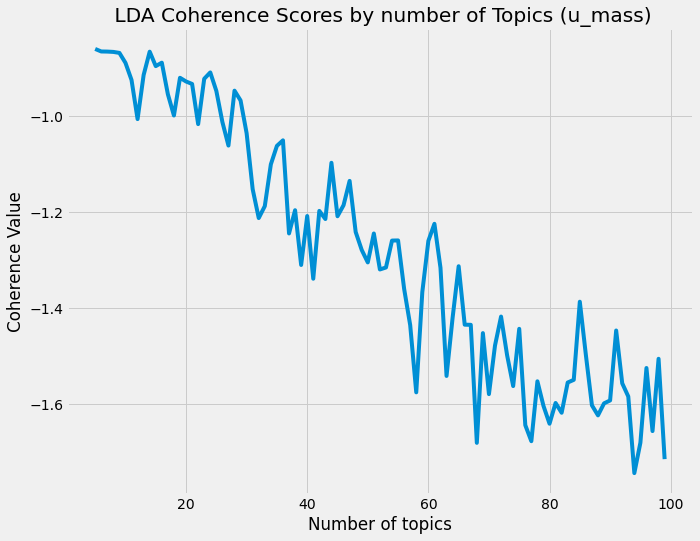

In [41]:
dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(Reviews_COVID)
min_topics, max_topics = 5, 100
coherence_scores_u_mass_lda, best_num_topics_u_mass_lda = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LDA', coherence_type='u_mass')
plot_coherence_scores(min_topics, max_topics, coherence_scores_u_mass_lda, coherence_type='u_mass', algorithm='LDA')

In [42]:
print('The best number of Review topics found by u-mass coherence score:', best_num_topics_u_mass_lda)

The best number of Review topics found by u-mass coherence score: 94


In [43]:
lda_model = print_topics(dictionary, bow_corpus, best_num_topics_u_mass_lda, algorithm='LDA', num_words=15, friendly_print=True)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


Topic 0: ['game', 'light', 'flashlight', 'batteri', 'phone', 'chill', 'review', 'bui', 'nice', 'simpl', 'dev', 'item', 'correct', 'rout', 'pattern']
Topic 1: ['game', 'like', 'plai', 'time', 'look', 'good', 'need', 'develop', 'lot', 'hour', 'thing', 'far', 'feel', 'build', 'fun']
Topic 2: ['game', 'plai', 'time', 'tower', 'bui', 'base', 'dai', 'topsid', 'think', 'dlc', 'come', 'raccoon', 'like', 'stori', 'thing']
Topic 3: ['tower', 'game', 'platinum', 'like', 'wave', 'enemi', 'time', 'start', 'titl', 'dlc', 'bui', 'new', 'item', 'extra', 'wast']
Topic 4: ['game', 'good', 'like', 'great', 'plai', 'us', 'need', 'end', 'time', 'stori', 'look', 'fun', 'wai', 'level', 'charact']
Topic 5: ['game', 'like', 'time', 'plai', 'great', 'book', 'look', 'jungl', 'recommend', 'feel', 'item', 'us', 'gameplai', 'new', 'addit']
Topic 6: ['game', 'good', 'color', 'purchas', 'lock', 'control', 'seq', 'look', 'plai', 'like', 'us', 'bad', 'want', 'feel', 'run']
Topic 7: ['plai', 'game', 'good', 'fun', 'visi

In [44]:
print_NMF_topics(tokenized_texts)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Topic 1: look,wai,hour,enemi,thing,feel,plai,like,time,game
Topic 2: badnergi,gameswhi,enadont,known,hunterloli,ena,hair,reason,monster,hunter
Topic 3: music,achiev,solv,jigsaw,simpl,piec,relax,easi,game,puzzl
Topic 4: satisfi,calm,develop,funni,dev,recommend,love,best,great,game
Topic 5: locomotivesit,want,free,pretti,gameplai,look,timekil,bore,game,good
Topic 6: multiplay,differ,worth,lot,crash,simpl,pretti,challeng,minut,fun
Topic 7: ye,free,song,outfit,ship,new,gun,great,bui,dlc
Topic 8: scene,choic,love,art,great,visual,end,novel,charact,stori
Topic 9: price,purchas,skin,art,bui,convert,pixel,color,pictur,pack
Topic 10: cat,lol,platform,kind,pretti,funni,wholesom,recommend,feel,like
Topic 11: peopl,recommend,iv,onlin,enjoi,mode,player,card,friend,plai
Topic 12: cool,visibl,nintendo,weapon,charm,miss,conced,game,recommend,awesom
Topic 13: uniron,tight,short,love,challeng,music,design,gameplai,platform,level
Topic 14: amaz,fix,thank,keyboard,big,younic,relax,work,ye,control
Topic 15

## Tags

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


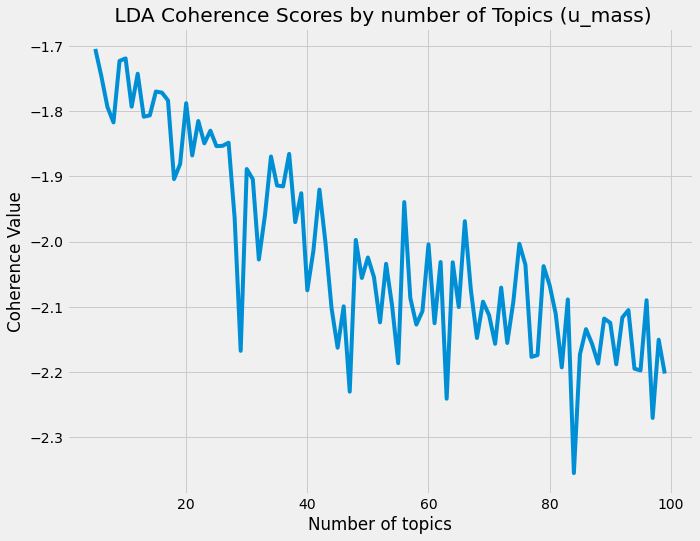

In [45]:
dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(Tags_COVID)
min_topics, max_topics = 5, 100
coherence_scores_u_mass_lda, best_num_topics_u_mass_lda = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LDA', coherence_type='u_mass')
plot_coherence_scores(min_topics, max_topics, coherence_scores_u_mass_lda, coherence_type='u_mass', algorithm='LDA')

In [46]:
print('The best number of Review topics found by u-mass coherence score:', best_num_topics_u_mass_lda)

The best number of Review topics found by u-mass coherence score: 84


In [47]:
lda_model = print_topics(dictionary, bow_corpus, best_num_topics_u_mass_lda, algorithm='LDA', num_words=15, friendly_print=True)

Topic 0: ['action', 'singleplay', 'indi', 'roguelik', 'firstperson', 'graphic', 'simul', 'pixel', 'perma', 'retro', 'death', 'rpg', 'adventur', 'realist', 'old']
Topic 1: ['shooter', 'singleplay', 'action', 'combat', 'hero', 'casual', 'arcad', 'indi', 'funni', 'game', 'parti', 'pve', 'platform', 'actionadventur', 'multiplay']
Topic 2: ['action', 'singleplay', 'indi', 'simul', 'world', 'manag', 'open', 'rpg', 'procedur', 'gener', 'build', 'sandbox', 'craft', 'access', 'adventur']
Topic 3: ['platform', 'adventur', 'color', 'rich', 'graphic', 'pixel', 'stori', 'game', 'cute', 'indi', 'singleplay', 'atmospher', 'scroller', 'fantasi', 'relax']
Topic 4: ['horror', 'singleplay', 'sim', 'sexual', 'shooter', 'content', 'psycholog', 'adventur', 'nuditi', 'indi', 'date', 'casual', 'action', 'puzzl', 'lgbtq']
Topic 5: ['shooter', 'action', 'combat', 'arena', 'singleplay', 'multiplay', 'indi', 'topdown', 'pve', 'gener', 'procedur', 'rpg', 'shoot', 'arcad', 'pvp']
Topic 6: ['educ', 'economi', 'modda

In [48]:
print_NMF_topics(tokenized_texts)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Topic 1: physic,casual,singleplay,indi,scroller,linear,adventur,puzzleplatform,precis,platform
Topic 2: jrpg,magic,wargam,war,fantasi,combat,rpg,tactic,strategi,turnbas
Topic 3: interact,adventur,matter,choic,end,multipl,novel,visual,stori,rich
Topic 4: fp,gore,stealth,actionadventur,adventur,dark,firstperson,surviv,psycholog,horror
Topic 5: atmospher,famili,friendli,minimalist,relax,logic,indi,singleplay,casual,puzzl
Topic 6: combat,thirdperson,scifi,arena,hell,bullet,shoot,action,topdown,shooter
Topic 7: arcad,parti,massiv,teambas,player,pvp,onlin,local,multiplay,coop
Topic 8: firstperson,manag,farm,build,realist,sandbox,life,immers,simul,sim
Topic 9: dark,magic,mediev,actionadventur,adventur,hack,slash,fantasi,action,rpg
Topic 10: casual,nsfw,matur,hentai,protagonist,femal,anim,nuditi,content,sexual
Topic 11: arcad,scroller,singleplay,topdown,indi,school,old,retro,pixel,graphic
Topic 12: difficult,crawler,action,dungeon,death,perma,roguelit,gener,procedur,roguelik
Topic 13: styliz,r

In [49]:
## LDAvis 

In [50]:
!pip install pyLDAvis==2.1.2

     |████████████████████████████████| 1.6 MB 8.4 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97738 sha256=6af3ce3d9dcc038e569cc509bc8b540028a55abdf82174793c5c361575d46c3a
  Stored in directory: /root/.cache/pip/wheels/3b/fb/41/e32e5312da9f440d34c4eff0d2207b46dc9332a7b931ef1e89
Successfully built pyLDAvis


In [51]:
import pyLDAvis.gensim

# Visualize the topics
pyLDAvis.enable_notebook()

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [52]:
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:232: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
31    -0.279505  0.086647       1        1  4.110506
73    -0.003584  0.006533       2        1  3.885480
10    -0.107029 -0.149323       3        1  3.592041
64    -0.182897  0.017803       4        1  3.388012
32     0.075673  0.203221       5        1  3.351161
...         ...       ...     ...      ...       ...
67    -0.010099 -0.025263      80        1  0.354595
13    -0.029158 -0.003115      81        1  0.334082
72    -0.005336  0.116173      82        1  0.291442
25    -0.040003  0.053078      83        1  0.254665
6     -0.031831 -0.091998      84        1  0.058652

[84 rows x 5 columns], topic_info=          Term        Freq       Total Category  logprob  loglift
76      horror  373.000000  373.000000  Default  30.0000  30.0000
160   platform  565.000000  565.000000  Default  29.0000  29.0000
48     shooter  514.000000  514.000000  Default  28.0000  28.0000
63    strategi  579.000000  579.000000  Default  27.0000  27.0000
0       action  892.000000  892.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
289    parkour    0.035611   34.146036  Topic84  -6.3173   0.5756
274      fight    0.035611   23.156564  Topic84  -6.3173   0.9639
276     vision    0.035611   21.065771  Topic84  -6.3173   1.0586
288     parodi    0.035611   18.162144  Topic84  -6.3173   1.2069
287  nonlinear    0.035611   38.879380  Topic84  -6.3173   0.4457

[4363 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
55        2  0.013967  abstract
55        3  0.083802  abstract
55        5  0.027934  abstract
55        6  0.013967  abstract
55        7  0.097769  abstract
...     ...       ...       ...
87       61  0.025868     zombi
87       65  0.012934     zombi
87       69  0.012934     zombi
87       75  0.025868     zombi
87       82  0.012934     zombi

[9351 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[32, 74, 11, 65, 33, 43, 59, 71, 24, 78, 75, 23, 49, 20, 39, 31, 60, 25, 15, 9, 47, 40, 45, 50, 6, 72, 83, 44, 21, 67, 46, 34, 29, 84, 42, 79, 3, 13, 70, 19, 52, 41, 69, 35, 58, 51, 28, 53, 10, 82, 81, 18, 38, 27, 63, 22, 1, 4, 2, 37, 5, 61, 56, 30, 48, 12, 55, 8, 76, 64, 62, 66, 16, 80, 77, 17, 54, 36, 57, 68, 14, 73, 26, 7])

# See Notebook 5.2 for text similarity analysis